## Loading Libraries

In [1]:
import pyreadr
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## Reading in Data

In [3]:
# Reading in Data
dataset = pyreadr.read_r("../data/brain.rda")

In [7]:
arraymeta_data = dataset['arraymeta']

In [9]:
expression_data = dataset['expression']

In [11]:
genemeta_data = dataset['genemeta']

## Initial EDA

### Counts from each brain region

In [13]:
# Determining the number of brain regions in each sample (apparently always 1)
arraymeta_data[['region.ancg', 'region.cb', 'region.dlpfc']].sum(axis=1).unique()

array([1.])

In [15]:
# Total number of samples from each brain region
arraymeta_data[['region.ancg', 'region.cb', 'region.dlpfc']].sum(axis = 0)

region.ancg     127.0
region.cb        81.0
region.dlpfc    178.0
dtype: float64

In [17]:
### Cross tab by brain region and lab
# Create factors for brain region and lab
arraymeta_data['region'] = arraymeta_data[['region.ancg', 'region.cb', 'region.dlpfc']].idxmax(axis=1).str.replace('region.', '')
arraymeta_data['lab'] = arraymeta_data[['lab.davis', 'lab.irvine', 'lab.michigan']].idxmax(axis=1).str.replace('lab.', '')

# Cross tab
cross_tab_region_lab = pd.crosstab(arraymeta_data['region'], arraymeta_data['lab'])

# Print results
print(cross_tab_region_lab)

lab     davis  irvine  michigan
region                         
ancg        0      66        61
cb         21      42        18
dlpfc      85       9        84


### Counts by age

In [19]:
### Cross tab by brain region and age
# Cross tab
cross_tab_br_age = pd.crosstab(arraymeta_data['age'], arraymeta_data['region'])

# Print results
# print(cross_tab_br_age)

In [21]:
### Cross tab by brain region and age ranges of interest
# Split pandas dataframe by age group
def categorize_age(age):
    if age < 70:
        return '<70'
    else:
        return '>=70'

arraymeta_data['age_group'] = arraymeta_data['age'].apply(categorize_age)

# Cross tab
cross_tab_region_agegrp = pd.crosstab(arraymeta_data['region'], arraymeta_data['age_group'])

# Print results
print(cross_tab_region_agegrp)

age_group  <70  >=70
region              
ancg       104    23
cb          70    11
dlpfc      146    32


Important to note that we have much more data for the less than 70 group than for the more than 70 group. Moving on to analysis of expression rates.

## Exploring Expression Rates

In [113]:
# Expression data, no controls
expression_data_NC = expression_data.loc[:, ~expression_data.columns.str.startswith('AFFX-')]

In [124]:
# Concatenate array metadata and gene expression data
# arraymeta_n_expression = pd.concat([arraymeta_data, expression_data], axis = 1)
# arraymeta_n_expression

In [63]:
expression_data_NC

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
0,8.597381,6.643790,6.742402,7.738635,6.477350,7.388334,6.734768,6.501485,6.312102,6.274967,...,7.408764,6.194929,6.577738,6.797697,6.808708,6.657397,6.667741,6.877755,7.829561,7.007025
1,7.507421,6.185789,6.377131,7.152656,6.002777,6.515969,6.430514,6.105450,5.947936,5.947524,...,6.923182,5.905811,6.624491,6.596047,6.408747,6.282058,6.308528,6.335732,7.147709,6.905695
2,9.151820,7.508944,7.924755,9.778946,6.991540,8.059766,8.198715,7.433385,7.047425,7.169980,...,8.654531,6.993808,7.941144,8.395062,8.109849,7.638189,7.777217,8.270511,9.153971,8.376190
3,9.480747,7.229395,7.330518,8.724294,6.897049,7.979412,7.213397,6.946586,6.530472,6.680387,...,8.076502,6.508246,7.272083,7.627558,7.452189,7.398643,7.221647,7.386523,8.627450,7.436969
4,10.855653,8.573288,8.519262,10.045489,8.053849,9.042049,8.379321,8.116254,7.623230,7.997303,...,9.345059,7.533039,8.439095,8.948477,8.827563,8.402366,9.082882,8.457960,10.078353,8.583880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,9.788715,7.990065,8.268939,9.392253,7.588384,8.461776,8.447588,7.858540,7.501698,7.341803,...,8.976301,7.395264,8.056124,8.249175,8.079989,7.871611,8.174875,8.620443,9.579849,8.046445
382,10.110330,8.193528,8.114450,9.403774,7.626703,8.505860,8.342483,7.791306,7.584267,7.535682,...,9.027578,7.284062,8.125525,8.589722,8.322550,7.880925,8.260587,8.548490,9.506943,8.071258
383,10.462571,8.496206,8.226372,9.683997,7.647338,8.811804,9.005109,8.074287,7.504952,7.727255,...,9.152998,7.364501,8.079706,8.494462,8.515618,8.145256,7.924811,8.534315,9.714715,8.488281
384,9.900810,8.147884,8.341852,9.359909,7.824822,8.437894,8.424120,7.839172,7.531454,7.402192,...,9.057280,7.584480,8.151156,8.061232,8.195951,7.987534,8.040881,8.605511,9.271022,8.048346


### PCA

In [31]:
# Separating out target
brain_region_target = arraymeta_data['region']

In [33]:
# Standardize the features
X_expression_NC = StandardScaler().fit_transform(expression_data_NC)

In [35]:
# Setting number of principal components
pca = PCA(n_components = 50)

In [37]:
# Extracting principal components
principalComponents = pca.fit_transform(X_expression_NC)

In [45]:
PC_df = pd.DataFrame(data = principalComponents)
final_PC_df = pd.concat([PC_df, brain_region_target], axis = 1)
final_PC_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,region
0,241.394620,-8.389363,-0.044469,12.885234,2.581314,-3.055921,14.431948,-2.148429,4.896703,-7.348053,...,-1.306615,-0.253001,2.274565,-0.513570,1.325590,0.881010,1.813917,-1.913053,1.578242,ancg
1,324.430258,10.076295,37.329415,10.567751,-10.350082,0.796032,20.941473,-4.337129,-1.204543,1.212140,...,2.701023,0.827477,-0.788886,0.653940,-2.313952,0.254079,-0.493064,-2.420201,0.927163,cb
2,31.354534,20.218450,27.855337,-16.860970,-5.221065,-2.054197,-6.708242,-0.435252,3.779758,-1.829315,...,0.457088,2.227547,1.436271,0.197372,-0.729551,0.856538,-0.591143,-1.389182,2.363408,cb
3,124.381406,-31.720574,-2.241897,0.279448,21.087420,-3.231646,8.064244,-1.411615,-11.896374,4.504296,...,0.920356,-0.068701,-0.933672,-0.708418,1.354807,-1.073108,0.460553,-2.137217,1.744769,dlpfc
4,-134.635472,-25.228737,-4.712797,18.630727,11.384066,-8.069399,-6.833284,7.110004,-14.782843,3.171621,...,2.855909,-0.194678,-3.508722,0.361874,-0.954625,-2.822196,3.226161,-2.634226,7.145575,dlpfc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,-49.243013,-0.321841,-21.112378,1.725965,-20.123499,-6.622513,-2.019680,-2.926181,-4.474775,-6.585416,...,1.821219,-3.570641,0.347765,-0.131776,1.267959,1.859035,-0.296884,0.773539,-1.040945,ancg
382,-61.321936,-17.044585,-14.799379,13.042483,-21.100090,-7.147367,-6.204182,-10.142042,-4.832193,1.425635,...,2.765802,-2.200774,-2.100789,-0.171047,1.665792,1.444559,-1.046886,-0.011918,2.441813,dlpfc
383,-97.064292,-33.355602,-10.021014,18.427506,-1.782453,1.041464,5.732291,-0.345490,12.595077,-13.237269,...,0.489885,2.644140,-0.460726,0.555565,1.310192,0.324874,4.153436,3.315919,1.554276,ancg
384,-64.008859,1.617070,-18.729140,11.610589,-23.017516,-7.669948,2.200760,-6.846546,-8.208843,-6.451569,...,0.890982,0.738833,0.694174,0.194104,-0.416499,-0.260270,-1.445746,2.501856,-1.137525,ancg


In [41]:
sum((pca.explained_variance_ / sum(pca.explained_variance_))[0:20])

0.9925083777950297

In [49]:
# Renaming columns
n = min(50, final_PC_df.shape[1])  # just in case there are < 50 cols
new_names = {old: f"PC{i+1}" for i, old in enumerate(final_PC_df.columns[:n])}
final_PC_df = final_PC_df.rename(columns=new_names)

In [51]:
final_PC_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,region
0,241.394620,-8.389363,-0.044469,12.885234,2.581314,-3.055921,14.431948,-2.148429,4.896703,-7.348053,...,-1.306615,-0.253001,2.274565,-0.513570,1.325590,0.881010,1.813917,-1.913053,1.578242,ancg
1,324.430258,10.076295,37.329415,10.567751,-10.350082,0.796032,20.941473,-4.337129,-1.204543,1.212140,...,2.701023,0.827477,-0.788886,0.653940,-2.313952,0.254079,-0.493064,-2.420201,0.927163,cb
2,31.354534,20.218450,27.855337,-16.860970,-5.221065,-2.054197,-6.708242,-0.435252,3.779758,-1.829315,...,0.457088,2.227547,1.436271,0.197372,-0.729551,0.856538,-0.591143,-1.389182,2.363408,cb
3,124.381406,-31.720574,-2.241897,0.279448,21.087420,-3.231646,8.064244,-1.411615,-11.896374,4.504296,...,0.920356,-0.068701,-0.933672,-0.708418,1.354807,-1.073108,0.460553,-2.137217,1.744769,dlpfc
4,-134.635472,-25.228737,-4.712797,18.630727,11.384066,-8.069399,-6.833284,7.110004,-14.782843,3.171621,...,2.855909,-0.194678,-3.508722,0.361874,-0.954625,-2.822196,3.226161,-2.634226,7.145575,dlpfc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,-49.243013,-0.321841,-21.112378,1.725965,-20.123499,-6.622513,-2.019680,-2.926181,-4.474775,-6.585416,...,1.821219,-3.570641,0.347765,-0.131776,1.267959,1.859035,-0.296884,0.773539,-1.040945,ancg
382,-61.321936,-17.044585,-14.799379,13.042483,-21.100090,-7.147367,-6.204182,-10.142042,-4.832193,1.425635,...,2.765802,-2.200774,-2.100789,-0.171047,1.665792,1.444559,-1.046886,-0.011918,2.441813,dlpfc
383,-97.064292,-33.355602,-10.021014,18.427506,-1.782453,1.041464,5.732291,-0.345490,12.595077,-13.237269,...,0.489885,2.644140,-0.460726,0.555565,1.310192,0.324874,4.153436,3.315919,1.554276,ancg
384,-64.008859,1.617070,-18.729140,11.610589,-23.017516,-7.669948,2.200760,-6.846546,-8.208843,-6.451569,...,0.890982,0.738833,0.694174,0.194104,-0.416499,-0.260270,-1.445746,2.501856,-1.137525,ancg


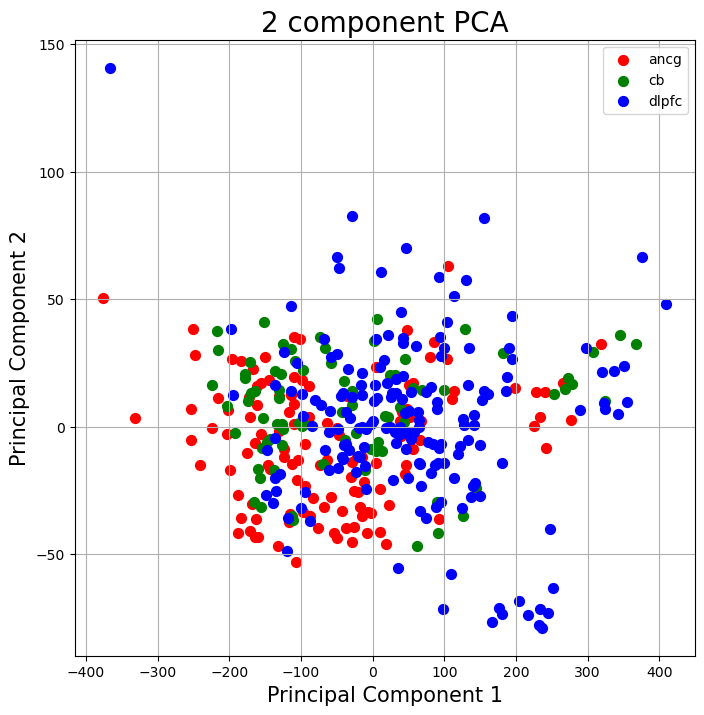

In [61]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['ancg', 'cb', 'dlpfc']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_PC_df['region'] == target
    ax.scatter(final_PC_df.loc[indicesToKeep, 'PC1']
               , final_PC_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### t-SNE Plot

In [205]:
# Standardize data if not done for PCA#
expression_data_NC = expression_data.loc[:, ~expression_data.columns.str.startswith('AFFX-')]
X_expression_NC = StandardScaler().fit_transform(expression_data_NC)

In [207]:
# Changing brain region targets into numbers
brain_region_target = arraymeta_data['region']
mapping = {'cb': 0, 'dlpfc': 1, 'ancg': 2}
number_target = brain_region_target.map(mapping)

In [209]:
# Initialize t-SNE model
tsne = TSNE(n_components = 2,
            perplexity = 5,
            random_state = 82803)

In [211]:
# Fit t-SNE model
X_tsne = tsne.fit_transform(X_expression_NC)

In [212]:
# Concatenate for plotting and rename
final_tsne_df = pd.concat([pd.DataFrame(X_tsne), brain_region_target], axis = 1)

# Rename
n = min(50, final_PC_df.shape[1])  # just in case there are < 50 cols
new_names = {old: f"vec{i+1}" for i, old in enumerate(final_tsne_df.columns[:n])}
final_tsne_df = final_tsne_df.rename(columns=new_names)

In [215]:
final_tsne_df

,vec1,vec2,vec3
0,-28.751646,-29.196880,ancg
1,-40.745319,-30.511812,cb
2,22.039387,-22.536015,cb
3,38.649826,-5.875682,dlpfc
4,-50.947140,22.774872,dlpfc
...,...,...,...
381,-19.817881,30.846157,ancg
382,-19.366108,32.629776,dlpfc
383,-39.712090,44.032543,ancg
384,-20.737617,30.470827,ancg


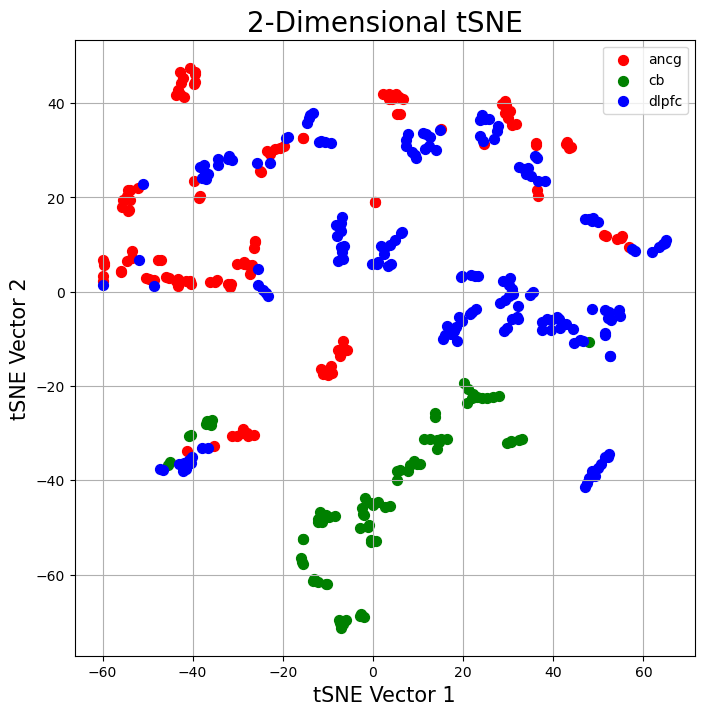

In [217]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('tSNE Vector 1', fontsize = 15)
ax.set_ylabel('tSNE Vector 2', fontsize = 15)
ax.set_title('2-Dimensional tSNE', fontsize = 20)

targets = ['ancg', 'cb', 'dlpfc']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_tsne_df['vec3'] == target
    ax.scatter(final_tsne_df.loc[indicesToKeep, 'vec1']
               , final_tsne_df.loc[indicesToKeep, 'vec2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()